## Sources
* Data: https://www.ntia.doc.gov/page/download-digital-nation-datasets
* Map (useful for checks!): https://www.ntia.doc.gov/data/digital-nation-data-explorer#sel=internetUser&disp=map
* Docs: https://www.ntia.doc.gov/files/ntia/publications/november-2019-techdocs.pdf
* Universes: https://www.ntia.doc.gov/files/ntia/data_central_downloads/code/create-ntia-tables-stata.zip

### Which weights?

For the weights, the 2019 sample documentation suggests `PWSSWGT` and `HWHHWGT` by default, and `PWPRMWGT` for the personal questions.  Let's just check this.

In [1]:
cps_test = pd.read_csv("data/nov19-cps.csv")

# Californian people...
ca = cps_test.query("(gestfips == 6) & (prtage >= 3) & (prpertyp != 3)")

ca.query("peinhome == 1").pwprmwgt.sum() / ca.pwprmwgt.sum(), \
ca.query("peinhome == 1").pwsswgt.sum() / ca.pwsswgt.sum() 

(0.9328654188139469, 0.7235029866408134)

If we exampine the [NTIA site](https://www.ntia.doc.gov/data/digital-nation-data-explorer#sel=homeInternetUser&disp=map), the number for California in 2019 is 72.4%.  So `pwsswgt` is right in this case -- it is not strictly within the used services category (email, texts, social, video, etc.).  Pay attention to exactly what it takes to reproduce the results on the official site.

How many people are in the sample?

In [2]:
(cps_test.pwsswgt > 0).sum()

117674

### Constructed variables.

For reference, see the stata code by Rafi Goldberg, <rgoldberg@ntia.doc.gov>

In [3]:
cps = pd.read_csv("data/nov19-cps.csv")
cps.query("pwsswgt > 0")

# cps = cps.filter(regex = "^((?!wgt[0-9]).)*$", axis = 1)

## Construct all the universe, following their cuts.
cps["isPerson"]      = (cps.prtage >= 3) & (cps.prpertyp != 3)
cps["isHouseholder"] = (cps.perrp > 0) & (cps.perrp < 3) & (cps.hrhtype > 0) & (cps.hrhtype < 9)
cps["isAdult"]       = cps.isPerson & (cps.prtage >= 15)
cps["isRespondent"]  = cps.puelgflg == 20

cps["P_at_home"]     = np.where(cps.isPerson, cps.peinhome == 1, np.nan)
cps["P_at_work"]     = np.where(cps.isPerson, cps.peinwork == 1, np.nan)
cps["P_at_school"]   = np.where(cps.isPerson, cps.peinschl == 1, np.nan)
cps["P_anywhere"]    = np.where(cps.isPerson, 
                                (cps.peinhome == 1) | (cps.peinwork == 1) | (cps.peinschl == 1) | \
                                (cps.peincafe == 1) | (cps.peintrav == 1) | (cps.peinlico == 1) | \
                                (cps.peinelho == 1) | (cps.peinothr == 1), 
                                np.nan)

cps["P_mobdat"]      = np.where(cps.isPerson, cps.hemobdat == 1, np.nan)

cps["P_computer"]    = np.where(cps.isPerson, (cps.pelaptop == 1) | (cps.pedesktp == 1), np.nan)
cps["P_smartphone"]  = np.where(cps.isPerson, cps.pemphone == 1, np.nan)

cps["P_email"]       = np.where(cps.isPerson, cps.peemail == 1, np.nan)
cps["P_text"]        = np.where(cps.isPerson, cps.petextim == 1, np.nan)
cps["P_social"]      = np.where(cps.isPerson, cps.pesocial == 1, np.nan)
cps["P_video"]       = np.where(cps.isPerson, cps.pevideo == 1, np.nan)
cps["P_services"]    = np.where(cps.isPerson, cps.peusesvc == 1, np.nan)


cps["H_at_home"]     = np.where(cps.isHouseholder, cps.heinhome == 1, np.nan)
cps["H_anywhere"]    = np.where(cps.isHouseholder, 
                                (cps.heinhome == 1) | (cps.heinwork == 1) | (cps.heinschl == 1) | \
                                (cps.heincafe == 1) | (cps.heintrav == 1) | (cps.heinlico == 1) | \
                                (cps.heinelho == 1) | (cps.heinothr == 1), 
                                np.nan)

# Reaons for non-use.
cps["H_nonuse_cost"] = np.where(cps.isHouseholder, cps.heprinoh.isin([2, 3]), np.nan)
cps["H_nonuse_no_interest"] = np.where(cps.isHouseholder, cps.heprinoh == 1, np.nan)
cps["H_nonuse_not_available"] = np.where(cps.isHouseholder, cps.heprinoh == 5, np.nan)

cps["H_smartphone"]  = cps.hemphone == 1
cps["H_computer"]    = (cps.helaptop == 1) | (cps.hedesktp == 1)

## NTIA constructs these as high speed conditional on internet, 
##   which I think is less useful than the non-conditional ACS construction, 
##   but we can do this to get their numbers.
HIGH_SPEED_CONDITIONAL = True
if HIGH_SPEED_CONDITIONAL:
    cps["H_highsp"] = np.where(cps.isHouseholder & (cps.H_anywhere == True), cps.hehomte1 == 1, np.nan)
    cps["H_mobdat"] = np.where(cps.isHouseholder & (cps.H_at_home  == True), cps.hemobdat == 1, np.nan)
else:
    cps["H_highsp"] = np.where(cps.isHouseholder, cps.hehomte1 == 1, np.nan)
    cps["H_mobdat"] = np.where(cps.isHouseholder, cps.hemobdat == 1, np.nan)

### Lots of contortions to get Census places.

Start with states, so we can check against "official" sources.

In [4]:
import psycopg2
from netrc import netrc

user, acct, passwd = netrc().authenticators("harris")

cen_con = psycopg2.connect(database = "census", user = user, password = passwd,
                           host = "localhost", port = 5432)

In [5]:
fips = pd.read_sql("SELECT fips, name FROM states;", index_col = "fips", con = cen_con).name.to_dict()
cps["state"] = cps.gestfips.replace(fips)

Population counts look right.

In [6]:
cps.groupby("state").pwsswgt.sum().loc[["Illinois", "California", "Pennsylvania"]] / 1e6

state
Illinois        12.497291
California      39.251506
Pennsylvania    12.622756
Name: pwsswgt, dtype: float64

### Construct city and CBSA populations.

In [7]:
cities = ["new_york", "los_angeles", "chicago", "houston", "phoenix",
          "philadelphia", "san_antonio", "san_diego", "dallas",
          "san_jose", "austin", "jacksonville", "san_francisco", "columbus",
          "fort_worth", "indianapolis", "charlotte", "seattle", "denver", "washington"]

city_dict = { # state, cbsa, city #
  "new_york"     : {"gestfips" : 36, "gtcbsa" : 35620, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "los_angeles"  : {"gestfips" :  6, "gtcbsa" : 31080, "gtcbsast" : 1, "gtindvpc" : 1, "gtco" :  37}, 
  "chicago"      : {"gestfips" : 17, "gtcbsa" : 16980, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "houston"      : {"gestfips" : 48, "gtcbsa" : 26420, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "phoenix"      : {"gestfips" :  4, "gtcbsa" : 38060, "gtcbsast" : 1, "gtindvpc" : 1},
  "philadelphia" : {"gestfips" : 42, "gtcbsa" : 37980, "gtcbsast" : 1, "gtindvpc" : 0, "gtco" : 101},
  "san_antonio"  : {"gestfips" : 48, "gtcbsa" : 41700, "gtcbsast" : 1, "gtindvpc" : 0}, 
  "san_diego"    : {"gestfips" :  6, "gtcbsa" : 41740, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "dallas"       : {"gestfips" : 48, "gtcbsa" : 19100, "gtcbsast" : 1, "gtindvpc" : 1},
  "san_jose"     : {"gestfips" :  6, "gtcbsa" : 41940, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "austin"       : {"gestfips" : 48, "gtcbsa" : 12420, "gtcbsast" : 1, "gtindvpc" : 0}, 
  "jacksonville" : {"gestfips" : 12, "gtcbsa" : 27260, "gtcbsast" : 1, "gtindvpc" : 0}, 
  "san_francisco": {"gestfips" :  6, "gtcbsa" : 41860, "gtcbsast" : 1, "gtindvpc" : 1, "gtco" :  75}, # SF county
  "columbus"     : {"gestfips" : 39, "gtcbsa" : 18140, "gtcbsast" : 1, "gtindvpc" : 0},
  "fort_worth"   : {"gestfips" : 48, "gtcbsa" : 19100, "gtcbsast" : 1, "gtindvpc" : 2}, 
  "indianapolis" : {"gestfips" : 18, "gtcbsa" : 26900, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "charlotte"    : {"gestfips" : 37, "gtcbsa" : 16740, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "seattle"      : {"gestfips" : 53, "gtcbsa" : 42660, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "denver"       : {"gestfips" :  8, "gtcbsa" : 19740, "gtcbsast" : 1, "gtindvpc" : 1}, 
  "washington"   : {"gestfips" : 11, "gtcbsa" : 47900, "gtcbsast" : 1, "gtindvpc" : 1}
}

cps["city"] = ""
for city, vals in city_dict.items():
    
    query = " & ".join(["({} == {:})".format(k, v)
                        for k, v in vals.items()])
    
    cps.loc[cps.query(query).index, "city"] = city
    
cps_city = cps[cps.city != ""].copy()

In [8]:
cbsa = ["new_york", "los_angeles", "chicago", "dallas-fort_worth", "houston", 
        "philadelphia", "washington", "miami", "atlanta", "boston", 
        "san_francisco", "riverside", "phoenix", "detroit", "seattle", 
        "minneapolis", "san_diego", "tampa", "st_louis", "baltimore"]

cbsa_dict = {
    35620 : "new_york", 31080 : "los_angeles", 16980 : "chicago", 19100 : "dallas-fort_worth", 26420 : "houston", 
    37980 : "philadelphia", 47900 : "washington", 33100 : "miami", 12060 : "atlanta", 14460 : "boston", 
    41860 : "san_francisco", 40140 : "riverside", 38060 : "phoenix", 19820 : "detroit", 42660 : "seattle", 
    33460 : "minneapolis", 41740 : "san_diego", 45300 : "tampa", 41180 : "st_louis", 12580 : "baltimore"
}

cps["cbsa"] = ""
cps.loc[cps.query("gtcbsa in @cbsa_dict").index, "cbsa"] = \
   cps.query("gtcbsa in @cbsa_dict").gtcbsa.replace(cbsa_dict)

cps_cbsa = cps[cps.cbsa != ""].copy()

In [9]:
# cps[["city", "gestfips", "gtcbsa", "gtcsa", "gtmetsta", "gtcbsast", "gtindvpc", "gtco"]]\
#    .query("city != ''").drop_duplicates().sort_values("city")

These populations seem about right... Washington DC is _way_ oversampled... weights are **necessary**.  In particular, San Francisco, where I had issues below is about 10% off of its "nominal" population (800k instead of 880k).

In [10]:
counts = cps_city.groupby("city").agg({"pwsswgt" : ["sum", "count"]})
counts.columns = ["population", "N"]
counts.sort_values(by = "population", ascending = False)

,population,N
city,,
new_york,8.278783e+06,2281
los_angeles,4.074095e+06,1215
chicago,2.496310e+06,748
houston,2.191824e+06,591
san_antonio,1.851952e+06,497
philadelphia,1.645956e+06,418
phoenix,1.523442e+06,474
san_diego,1.292693e+06,374
fort_worth,1.138746e+06,272


(200,)

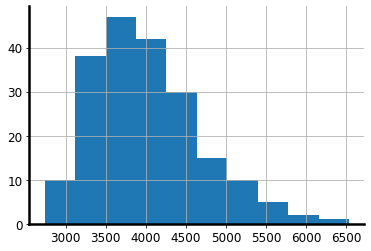

In [11]:
cps_city[(cps_city.city == "san_francisco") & (cps_city.pwsswgt > 0)].pwsswgt.hist()
cps_city[(cps_city.city == "san_francisco") & (cps_city.pwsswgt > 0)].pwsswgt.shape

### Construct the basic variables.

If the `HIGH_SPEED_CONDITIONAL` is true, this will give the NTIA results for states.

Internet in home.

In [12]:
def weighted_mean(G, w): return G._get_numeric_data().multiply(G[w],  axis=0).sum()/G[w].sum()

def access(df, grouper):
    
    hwss_vars =  df.query("isHouseholder").groupby(grouper).apply(weighted_mean, w = "hwhhwgt")\
                   [["H_mobdat", "H_highsp"]]
        
    hwss_vars_use =  df.query("isHouseholder & (H_at_home == False)")\
                       .groupby(grouper).apply(weighted_mean, w = "hwhhwgt")\
                       [["H_nonuse_cost", "H_nonuse_no_interest", "H_nonuse_not_available"]]
    
    pwss_vars =  df.query("isPerson").groupby(grouper).apply(weighted_mean, w = "pwsswgt")\
                   [["P_at_home", "P_at_work", "P_anywhere", "P_smartphone", "P_computer"]] 

    pwpr_vars =  df.query("isRespondent").groupby(grouper).apply(weighted_mean, w = "pwprmwgt")\
                   [["P_email", "P_text", "P_social", "P_video", "P_services"]]
        
    complete = pd.concat([pwss_vars, pwpr_vars, hwss_vars, hwss_vars_use], axis = 1).round(3)
        
    complete = complete[["P_at_home", "P_anywhere", "H_mobdat", "H_highsp", "P_at_work", 
                         "P_smartphone", "P_computer", 
                         "P_email", "P_text", "P_social", "P_video", "P_services", 
                         "H_nonuse_cost", "H_nonuse_no_interest", "H_nonuse_not_available"]] 
    
    complete.sort_values(by = "P_at_home", inplace = True)
    
    complete.index = complete.index.str.replace("_", " ").str.title()

    return complete
    

### States

In [13]:
access(cps, "state").style.background_gradient(cmap = "viridis")

,P_at_home,P_anywhere,H_mobdat,H_highsp,P_at_work,P_smartphone,P_computer,P_email,P_text,P_social,P_video,P_services,H_nonuse_cost,H_nonuse_no_interest,H_nonuse_not_available
state,,,,,,,,,,,,,,,
North Carolina,0.682000,0.743000,0.627000,0.631000,0.279000,0.640000,0.523000,0.863000,0.890000,0.718000,0.718000,0.248000,0.225000,0.577000,0.012000
Mississippi,0.688000,0.759000,0.665000,0.539000,0.226000,0.643000,0.461000,0.824000,0.913000,0.775000,0.662000,0.135000,0.191000,0.605000,0.070000
West Virginia,0.692000,0.773000,0.615000,0.637000,0.240000,0.609000,0.528000,0.847000,0.865000,0.741000,0.708000,0.133000,0.223000,0.597000,0.033000
Tennessee,0.693000,0.762000,0.686000,0.632000,0.287000,0.639000,0.572000,0.859000,0.925000,0.737000,0.685000,0.291000,0.266000,0.556000,0.031000
Nevada,0.698000,0.778000,0.707000,0.700000,0.300000,0.656000,0.567000,0.925000,0.927000,0.709000,0.681000,0.374000,0.114000,0.616000,0.048000
Louisiana,0.699000,0.763000,0.681000,0.597000,0.278000,0.668000,0.493000,0.850000,0.933000,0.752000,0.735000,0.225000,0.186000,0.602000,0.047000
New Mexico,0.705000,0.785000,0.680000,0.642000,0.276000,0.658000,0.512000,0.894000,0.898000,0.686000,0.748000,0.322000,0.153000,0.729000,0.005000
Florida,0.707000,0.773000,0.675000,0.697000,0.295000,0.664000,0.577000,0.928000,0.927000,0.732000,0.696000,0.306000,0.162000,0.664000,0.011000
Kentucky,0.707000,0.785000,0.667000,0.582000,0.304000,0.664000,0.525000,0.855000,0.928000,0.766000,0.754000,0.217000,0.206000,0.531000,0.034000


### Cities

In [14]:
access(cps_city, "city").sort_values("H_highsp").style.background_gradient(cmap = "viridis", axis = 0)

,P_at_home,P_anywhere,H_mobdat,H_highsp,P_at_work,P_smartphone,P_computer,P_email,P_text,P_social,P_video,P_services,H_nonuse_cost,H_nonuse_no_interest,H_nonuse_not_available
city,,,,,,,,,,,,,,,
Indianapolis,0.597000,0.647000,0.523000,0.543000,0.275000,0.568000,0.414000,0.883000,0.955000,0.660000,0.703000,0.355000,0.187000,0.677000,0.000000
Chicago,0.647000,0.730000,0.620000,0.600000,0.296000,0.639000,0.500000,0.879000,0.914000,0.705000,0.795000,0.450000,0.134000,0.646000,0.027000
San Francisco,0.613000,0.634000,0.612000,0.614000,0.397000,0.633000,0.590000,0.963000,0.933000,0.750000,0.816000,0.730000,0.060000,0.658000,0.069000
Los Angeles,0.701000,0.763000,0.717000,0.621000,0.301000,0.722000,0.563000,0.885000,0.927000,0.773000,0.794000,0.532000,0.203000,0.554000,0.039000
Houston,0.635000,0.689000,0.638000,0.623000,0.242000,0.632000,0.442000,0.851000,0.909000,0.669000,0.816000,0.413000,0.241000,0.565000,0.000000
Philadelphia,0.677000,0.746000,0.664000,0.638000,0.299000,0.626000,0.504000,0.901000,0.965000,0.784000,0.829000,0.549000,0.136000,0.643000,0.000000
Phoenix,0.701000,0.734000,0.682000,0.651000,0.314000,0.716000,0.562000,0.935000,0.967000,0.751000,0.840000,0.434000,0.229000,0.476000,0.023000
San Antonio,0.666000,0.714000,0.697000,0.667000,0.304000,0.636000,0.537000,0.920000,0.939000,0.775000,0.837000,0.423000,0.175000,0.576000,0.000000
Jacksonville,0.740000,0.788000,0.725000,0.671000,0.292000,0.698000,0.634000,0.905000,0.962000,0.850000,0.754000,0.261000,0.244000,0.656000,0.000000


The fact that SF is low still feels really weird.

In [15]:
sf = cps.query("(gestfips == 6) & (gtcbsa == 41860) & (gtcbsast == 1) & (gtco == 75) & (gtindvpc == 1)")
sf.query("heinhome == 1").hwhhwgt.sum() / sf.query("heinhome > 0").hwhhwgt.sum()

0.6602834922747424

Note that if there is no internet connection, the high speed questions don't get asked!!  Pay attention to the Universe!!

### CBSA

In [16]:
access(cps_cbsa, "cbsa").sort_values("H_highsp").style.background_gradient(cmap = "viridis", axis = 0)

,P_at_home,P_anywhere,H_mobdat,H_highsp,P_at_work,P_smartphone,P_computer,P_email,P_text,P_social,P_video,P_services,H_nonuse_cost,H_nonuse_no_interest,H_nonuse_not_available
cbsa,,,,,,,,,,,,,,,
Detroit,0.689000,0.733000,0.652000,0.634000,0.285000,0.649000,0.555000,0.890000,0.923000,0.698000,0.701000,0.302000,0.122000,0.669000,0.000000
Los Angeles,0.684000,0.744000,0.704000,0.646000,0.271000,0.677000,0.532000,0.883000,0.930000,0.754000,0.772000,0.482000,0.198000,0.566000,0.038000
Houston,0.711000,0.756000,0.703000,0.666000,0.288000,0.673000,0.530000,0.905000,0.937000,0.725000,0.773000,0.332000,0.246000,0.581000,0.021000
Atlanta,0.750000,0.797000,0.712000,0.671000,0.325000,0.710000,0.622000,0.938000,0.936000,0.699000,0.746000,0.411000,0.245000,0.603000,0.043000
St Louis,0.753000,0.809000,0.728000,0.690000,0.342000,0.684000,0.609000,0.911000,0.892000,0.750000,0.756000,0.378000,0.203000,0.525000,0.016000
San Diego,0.731000,0.806000,0.672000,0.695000,0.335000,0.707000,0.620000,0.912000,0.927000,0.736000,0.780000,0.523000,0.229000,0.541000,0.076000
Miami,0.702000,0.760000,0.689000,0.696000,0.310000,0.679000,0.584000,0.907000,0.944000,0.711000,0.653000,0.347000,0.147000,0.702000,0.000000
Riverside,0.715000,0.765000,0.723000,0.702000,0.264000,0.683000,0.520000,0.877000,0.927000,0.775000,0.743000,0.324000,0.211000,0.638000,0.023000
Chicago,0.767000,0.825000,0.721000,0.709000,0.344000,0.705000,0.621000,0.909000,0.920000,0.724000,0.766000,0.415000,0.136000,0.664000,0.032000


In [17]:
why_no_net = {
  1  : "Don't need it or not interested",
  2  : "Can't afford it",
  3  : "Not worth the cost",
  4  : "Can use it elsewhere",
  5  : "Not available in area",
  6  : "No device",
  7  : "Privacy or security concerns",
  8  : "Safety concerns",
  9  : "Moving",
  10 : "Other",
  -1 : "NA"
}

cps["why_no_net"] = cps.heprinoh.replace(why_no_net)

cps.query("heprinoh > 0").why_no_net.value_counts()

Don't need it or not interested    11188
Can't afford it                     3257
Other                               1707
Not available in area                831
Can use it elsewhere                 646
Not worth the cost                   520
No device                            478
Privacy or security concerns         299
Moving                                97
Safety concerns                       77
Name: why_no_net, dtype: int64

In [18]:
# print([x for x in cps.columns if "wgt" not in x])

### CSA doesn't work.... 

Missing: 288 houston, 420 phoenix, 476 st louis

In [19]:
csa = {"new_york" : 408, "los_angeles" : 348, "chicago" : 176, "washington" : 548, "san_jose" : 488, 
       "boston" : 148, "dallas-fort_worth" : 206, "houston" : 288, "philadelphia" : 428, "miami" : 370,
       "atlanta" : 122, "detroit" : 220, "phoenix" : 429, "seattle" : 500, "orlando" : 422, 
       "minneapolis" : 378, "denver" : 216, "cleveland" : 184, "portland" : 440, "st_louis" : 476}